Introduction
=======

Expressions in **Prove-It** are fundamental and versatile.  In order to prove some statement, you must be able to express the statement that you want to prove, and express each axiom and each theorem that is used to construct the proof as well as intermediate statements along the way.  Statements and proofs will be discussed in later tutorials.  Here we focus on the expressions themselves.  In **Prove-It**, an expression is a tree-like data structure (technically a directed acyclic graph, DAG, since there may be multiple instances of the same sub-expression).  As a Python object, its base class is `proveit._core_.expr.Expression` (also aliased as `proveit.Expression` via `from ... import ...` statements within `__init__.py` files).  It must have an intermediate class in the class inheritance hierarchy that is one of the "core" **Expression** classes which governs how the expression behaves when used in a proof (specifically governing the **specialize** derivation step which will be discussed in subsequent tutorials).  

In the **Prove-It** philosophy, expression representations should be explicit, not implicit.  To this end, the external representation of how an expression is displayed should be a true reflection of its internal representation (with some caveats regarding **Literal**s that will be discused below).  That way, there is no ambiguity and no confusion.  Rather than exploiting equivalences of expressions implicitly, all transformations are enabled by explicit, traceable axioms.  As a consequence, however, **Prove-It** is not a minimalist approach with respect to types of expressions or with respect to numbers of axioms.  One example is currying.  Named for Haskell Curry, this is a minimalistic way to avoid multi-argument functions by expanding them as nested single-argument functions; however, the **Prove-It** philosophy is to be explicit about using multi-argument operations when one wishes to express statements in that form.

The following are the core **Expression** classes that enable a variety of explicit forms of expressions.  A brief description is provided for each class, but these concepts will become more clear by considering examples shown below.
* **Label**: A label for a mathematical object (e.g., a symbol).
    * **Variable**: A label with no contextual meaning.
    * **MultiVariable**: A placeholder for zero or more **Variable**s, indicated with one or more dummy, symbolic indexing **Label**s.
    * **Literal**: A label with contextual meaning that is bound to some *context* (specified as a Python package).
* **Lambda**: Represents a mathematical mapping or function; contains the *arguments* (an **ExpressionList** of **Variable**s or **MultiVariable** **Bundle**s that are being mapped) and an *expression* (any **Expression** that the arguments are to be mapped into).
* **Operation**: Represents an applied operation; contains an *operator* (a **Label** or **Lambda**) and *operands* (a **Composite**).
* **Composite**: An **Expression** that contains multiple **Expression**s in a collection.
    * **NamedExpressions**: Maps keyword strings into **Expression**s.
    * **ExpressionList**: A 1-dimensional collection of **Expressions**s.
    * **ExpressionTensor**: A multi-dimensional collection of **Expression**s.
* **Bundle**: A placeholder for a portion of a **Composite**. 
    * **Etcetera**: A placeholder for a portion of an **ExpressionList**.
    * **Block** A placeholder for a portion of an **ExpressionTensor**.

Developers and users may derive from core **Expression** classes (**Literal** and **Operation** classes in particular) to make their own **Expression** classes that have special formatting rules and methods for manipulating and utilizing the expression.  The formatting should ideally be in direct correspondence with the structure of the **Expression** in regards to core **Expression** classes (a true reflection of the internal representation as stated above), but there is no enforcement mechanism to ensure that this is the case.  Users are advised to inspect the fully explicit expression DAG by calling `exprInfo()` on the **Expression** object, to ensure that the formatting properly reflects the internal content (or rely on crowd-source checking of axioms/theorems).

The remainder of this tutorial will show examples and discuss details of the different core **Expression** classes (types).

As we discuss these different core types we will discuss the instances when different expressions are considered to be the same or different.  This is important because it corresponds to whether or not statements are the same or not, and that is important because a statement is proven if it is the same as another statement that has been proven.

We will also discuss *expression substitution/relabeling* as we go through the different cases.  The following are related but distinct manipulations in **Prove-It**:
* *Expression substutition*: creating a new **Expression** from an existing **Expression** by swapping one or more sub-expression(s) for other sub-expression(s).  This creates a new **Expression** but has nothing to do, intrinsically, with proving statements.
* *Expression relabeling*: a restricted version of *expression substitution* in which any **Variable** may be relabeled only with another **Variable** or any **MultiVariable** may be relabeled with another **MultiVariable** or a list of **Variable**s.
* Statement *specialization*: deriving a statement of the form $P(y)$ from a statement of the form $\forall_x P(x)$.  Details of this will be discussed in a later tutorial, but this manipulation uses *expression substitution* in generating $P(y)$.  However, specific rules and limitations apply to *specialization* that may not apply to *expression substitution* to ensure that the derivation is sound.  It specifically involves statements with the $\forall$ quantifier.
* *Statement relabeling*: deriving a statement from another statement which differs only in its **Variable**s or **MultiVariable**s, or replaces **MultiVariable**s with a list if **Variable**s.  For example, from $\forall_x P(x)$, we could use *relabeling* to derive $\forall_y P(y)$.  It works the same way as *expression relabeling* but is applied in the context of a proof derivation.
* *Equality substitution*: using the **substitution** axiom of `proveit.logic.equality` to prove that $f(x) = f(y)$ given $x = y$.  This uses *statement specialization* of the **substitution** axiom which state $\forall_{f, x, y} ((x = y) \Rightarrow (f(x) = f(y)))$.  This specifically involves statements with the `proveit.logic.equality.eqOps.Equals` **Literal**. This will be discussed in a later tutorial.

The focus here will be *expression substitution/relabeling* with some mention of the additional restrictions applicable to *statement specialization/relabeling*.  It is important to understand the distinction of these three kinds of manipulations.  Reminders will be given throughout the tutorials.

Labels: Variable, MultiVariable, and Literal
================================

In [1]:
from proveit import Label, Variable, MultiVariable, Literal

Label
-----

**Variable**, **MultiVariable**, and **Literal** derive from the **Label** class.

In [2]:
# A Label has a string format and a latex format
triangle = Label(stringFormat='triangle', latexFormat=r'\triangle')
triangle # the latex is processed and displayed in IPython

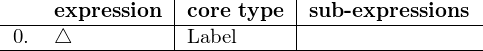

In [3]:
# The Label's expression info shows that it has a core type of Label and no sub-expressions.
triangle.exprInfo() # the expressions and sub-expressions are numbered with the top level being zero.

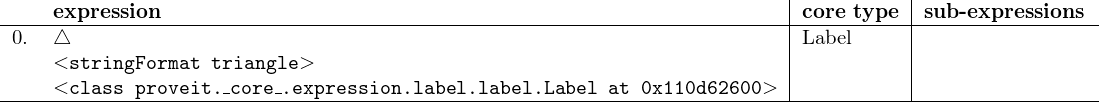

In [4]:
# This information is technically not complete for the purpose of distinguishing expressions.
triangle.exprInfo(details=True) # the string format and class is also important

In [5]:
# Two Label's are regarding to be the same expression iff both formats, and the class, are the same.
print "== when both formats are the same: ", (triangle == Label('triangle', r'\triangle'))
print "== when one format is different: ", (triangle == Label('tri', r'\triangle'))

class Triangle(Label):
    def __init__(self):
        Label.__init__(self, 'triangle', r'\triangle')
print "== when the class is different: ", triangle == Triangle()

== when both formats are the same:  True
== when one format is different:  False
== when the class is different:  False


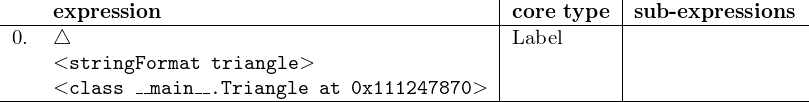

In [6]:
# See that the class difference shows up when displaying expression information with details=True
Triangle().exprInfo(details=True)

In [7]:
# let's make another label to test out substituted and relabeled methods
square =  Label(stringFormat='square', latexFormat=r'\Box')
square

Using *expression substitution*, we can change one **Label** into another or any other **Expression**.  We'll see that *specialize* is more restrictive; only applicable to **Variable**s and not any **Label**, but for *expression substition* this is fine.

In [8]:
triangle.substituted({triangle:square})

Using *expression relabeling*, the **Label** does not change because only **Variable**s and **MultiVariable**s may be relabeled.

In [9]:
triangle.relabeled({triangle:square})

Variable
--------
A **Variable** is an interchangeable label with no formal, contextual meaning.

In [10]:
x = Variable('x') # the string and latex formats are the same by default
x

In [11]:
omega = Variable(stringFormat='omega', latexFormat=r'\omega') # different string and latex format
omega 

As a convention, convenient Variables and Expressions are contained in **common** modules in various packages.  That is, **common** modules hold common expressions:

In [12]:
from proveit.common import a, b, c, x, y, z, alpha
alpha

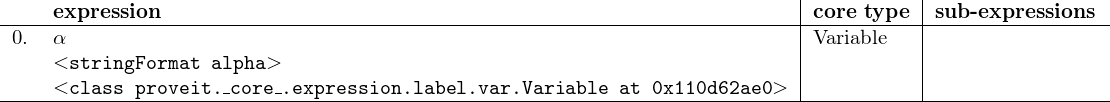

In [13]:
# Expression information is similar to the Label, but with the different core type and class
alpha.exprInfo(details=True)

Just as we saw for the generic **Label** **Expression**s, we can use *expression substitution* to exchange one **Variable** for another or any other **Expression**.  Furthermore, we will see in a later tutorial that **Variable**s have special properties with respect to *specialization* because they are defined as interchangeable labels.

In [14]:
alpha.substituted({alpha:omega})

Unlike generic **Label** **Expression**s, we can use *expression relabeling* to change a **Variable** into a different **Variable**, and only a **Variable**.  **Variable**s have special properties with respect to *relabeling*.

In [15]:
alpha.relabeled({alpha:omega})

In [16]:
from proveit import ImproperRelabeling
try:
    alpha.relabeled({alpha:square})
except ImproperRelabeling:
    print "EXPECTED ERROR: May only relabel a Variable with a Variable"

EXPECTED ERROR: May only relabel a Variable with a Variable


Literal
-------

A **Literal** is another kind of **Label**.  In contrast to **Variable**s, **Literal**s have a formal, contextual meaning. They are bound to a *context* (as a Python package) and endowed with meaning via axioms as will be discussed later.  Below are different scenarios in which a **Literal** could appropriately be used.  For our example **Literal**s, we will use 'tutorial' as the context.  The context should be set to the full name of the package where the **Literal** is defined. 

### Specific operators

In [17]:
TIMES = Literal(context='tutorial', stringFormat='*', latexFormat=r'\times')
TIMES # By convention, Literal operators are ALL-CAPS

In [18]:
FACTORIAL = Literal('tutorial', '!')
FACTORIAL

In [19]:
SUMMATION = Literal('tutorial', 'sum', r'\sum')
SUMMATION

### Constant values

In [20]:
FIVE = Literal('tutorial', '5')
FIVE

In [21]:
TRUE = Literal('tutorial', 'true', r'\top')
TRUE # By convention, Literal constants are also ALL-CAPS

In [22]:
FALSE = Literal('tutorial', 'false', r'\bot')
FALSE

### Contextual "variables"

This is appropriate when variables are given a specific meaning within the context of a problem.  For example, consider a math "story problem" where Andrea has $a$ apples and Bill has $b$ bananas.  These are variables in a sense, but here they have contextual meaning so they should be **Literal**s.  However, suppose one wants to prove a general theorem for any number of Andrea's apples and Bill's bananas.  One may start by using the $a$ and $b$ **Literal**s for convenience for some contextual "lemmas" (although it should be noted that Prove-It does not distinguish between lemmas and theorems), but then demote them to **Variable**s in order to make a statement of the form $\forall_{a, b} P(a, b)$ (**Literal**s may not be quantified over).  This is done by using a process called axiom elimination that will be discussed later.  For now, we just note that "variables" with contextual meaning need to be **Literal**s.

In [23]:
aLit = Literal('tutorial', 'a')
aLit

In [24]:
bLit = Literal('tutorial', 'b')
bLit

In [25]:
print "== between Variable a and Literal a:", a == aLit
print "== between Variable a and Literal a as a Variable:", a == aLit.asVariable()

== between Variable a and Literal a: False
== between Variable a and Literal a as a Variable: True


There is a potential source of confusion when a **Literal** and a **Variable** are displayed in the same way.  Our solution is for **Prove-It** to check for such mistakes and raise appropriate exceptions that alert the user to the problem.  For example, users will be alerted when attempting to quantify over a **Literal** that there may be such a mix up.  Also, when equivalence is checked between **Expression**s, we check the equivalence when all **Literal**s are converted to their corresponding **Variable**s via the **asVariable()** method to see if that changes the conclusion regarding equivalence. 

*__THIS `asVariable()` EQUIVALENCE CHECK IS NOT YET IMPLEMENTED__*

### Literal substitution
It is possible to perform *expression substitution* on a **Literal**.  However, *specialization* is not allowed because you cannot quantify over a **Literal** like you can a **Variable**.

In [26]:
aLit.substituted({aLit:bLit})

In [27]:
aLit.substituted({aLit:omega})

*Relabeling* is also not allowed since **Literal**s are not interchangeable.

In [28]:
aLit.relabeled({aLit:bLit})

### Literal expression comparision

Not only are **Literal**s and **Variabe**s regarded as different **Expression**s even if they have the same formatting, **Literal**s with different contexts are regarded as different even if they have the same formatting.

In [29]:
# Let's rename our 'tutorial' TRUE/FALSE and import TRUE/FALSE from proveit.logic, one of the main context packages
tutorialTrue = TRUE
tutorialFalse = FALSE
from proveit.logic import TRUE, FALSE

In [30]:
# When the context is different, they are not the same.
TRUE == tutorialTrue

False

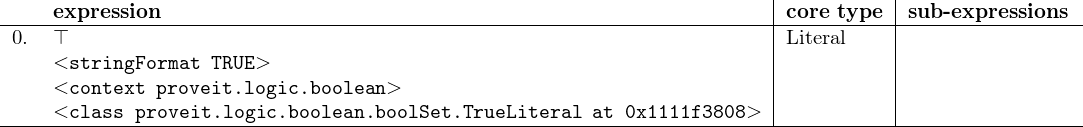

In [31]:
# The detailed expression information reveals the differences.
TRUE.exprInfo(details=True)

Note that the `TRUE` **Expression** has a different class than the basic **Literal** class.  This is desirable whenever we wish to make special methods that are specific to a particular kind of expression.  In the case of the `TRUE` and `FALSE` **Literal**s that we have imported from `proveit.logic`, `evalEquality(..)` is convenient method for invoking any of the following true statements: $(\top = \top) = \top$, $(\bot = \bot) = \top$, $(\top = \bot) = \bot$, or $(\bot = \top) = \bot$ as desired (these are proven theorems within `proveit.logic`).

In [32]:
TRUE.evalEquality(FALSE)

Lambda
====

Represents a mathematical mapping or function; contains the *arguments* (an **ExpressionList** of **Variable**s or **MultiVariable** **Bundle**s that are being mapped) and an *expression* (any **Expression** that the arguments are to be mapped into).

In [33]:
from proveit import Lambda

In [34]:
# maps any value to 5
mapTo5 = Lambda(x, FIVE) 
mapTo5

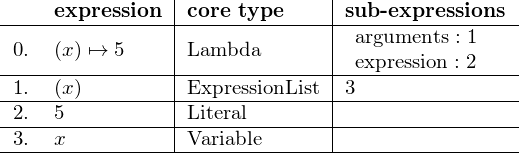

In [35]:
# Let's look at the Expression info
mapTo5.exprInfo()

Although we are mapping a single argument in this example, $x$, the *arguments* is an **ExpressionList**.  This is just for consistency with cases in which we have multiple arguments as in the next example.

In [36]:
# Can have multiple arguments, and the lambda's expression may involve any of these arguments
lambdaExpr = Lambda([x, omega], z)
lambdaExpr

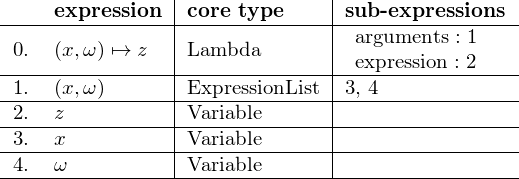

In [37]:
# Expression info shows how the Lambda is broken down into arguments and the expression as sub-expression.
lambdaExpr.exprInfo()

**ExpressionList**s will be discussed in more detail in a later section of this tutorial.

A very important property of a **Lambda** is that it defines a new "scope" for its arguments.  The argument **Variable**s may be *relabeled*, but they will not be substituted.

In [38]:
lambdaExpr.relabeled({x:y})

In [39]:
lambdaExpr.substituted({x:aLit})

In [40]:
# We can substitute a Variable that is not an argument, however.
lambdaExpr.substituted({z:aLit})

There are important limits regarding *relabeling* and *substitution* within the "scope" of the **Lambda**.  In particular, arguments of the Lambda function are "reserved" and may not be used in *substitution* or *relabeling*.  Otherwise, you could alter the meaning of the **Expression** in unintended ways and invalidate the proof generation.

In [41]:
from proveit import ScopingViolation
try:
    Lambda([x, omega], z).substituted({z:omega})
except ScopingViolation as e:
    print "EXPECTED ERROR: ", e
try:
    Lambda([x, omega], z).relabeled({z:omega})
except ScopingViolation as e:
    print "EXPECTED ERROR: ", e

EXPECTED ERROR:  Must not make substitution with reserved variables  (i.e., arguments of a Lambda function)
EXPECTED ERROR:  Relabeling in violation of Variable scoping restrictions.


In [42]:
# In addition, Lambda argument Variables must be distinct
from proveit import ImproperSubstitution
try:
    Lambda([x, omega], z).relabeled({x:omega})
except ImproperSubstitution as e:
    print "EXPECTED ERROR: ", e

EXPECTED ERROR:  Lambda argument Variables must be unique with respect to each other.


It is possible, however, to perform simultaneous *relabeling* that is consistent (retains the meaning).

In [43]:
lambdaExpr2 = Lambda([x, omega], x)
lambdaExpr2

In [44]:
lambdaExpr2.relabeled({x:omega, omega:x})

Operation
=========

Represents an applied operation; contains an operator (a Label or Lambda) and operands (a Composite).

In [45]:
from proveit import Operation

In [46]:
# Simple case: a Variable operator with a single Variable operand
f = Variable('f')
fx = Operation(f, x)
fx # f(x)

Common forms of these are available from **proveit.common**:

In [47]:
from proveit.common import fx, gx
gx

Let's derive a class from Operation for a kind of operation with a specific literal operand.
This is commonly done in building Prove-It libraries.

In [48]:
class Factorial(Operation):
    
    def __init__(self, operand):
        # creates the Operation with FACTORIAL as the operator and the provided operand as its only operand.
        Operation.__init__(self, FACTORIAL, operand)
        self.operand = operand # store this here for convenience

    '''
    The operatorOfOperation class method is necessary to use the default version of Operation.make
    that is important for substitution and relabeling.
    '''
    @classmethod
    def operatorOfOperation(subClass):
        return FACTORIAL 
    
    def string(self, **kwargs): # should accept kwargs even when not used (e.g., 'fence')
        # the operand should be fenced (wrapped in parentheses) to prevent ambiguity
        return self.operand.string(fence=True) + self.operator.string()
    
    def latex(self, **kwargs): # should accept kwargs even when not used (e.g., 'fence')
        # the operand should be fenced (wrapped in parentheses) to prevent ambiguity
        return self.operand.latex(fence=True) + self.operator.latex() 

A **Factorial** is an **Operation** with **FACTORIAL** as the **Literal** operator.  Its formatting is altered from the default but is still true (in a 1-to-1 correspondence) to the core **Expression** structure.

In [49]:
# Now we can make an object with this new class
xFactorial = Factorial(x)
xFactorial

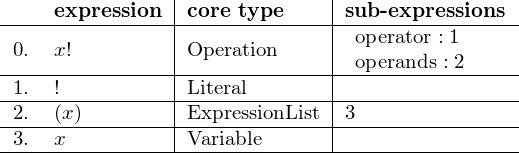

In [50]:
# show core structure
xFactorial.exprInfo()

In the IPython notebook setting, we just need the latex formatting, but it is always a good idea to define the string formatting for whenever it is needed.  The `fence=True` above indicates that parentheses should be used when it could be ambiguous otherwise.  Our example above has no ambiguity, so parentheses are not used.  We will show a case below where the parentheses are required.

As with **Lambda** *arguments*, **Operation** *operands* is an **ExpressionList** even when there is one operand for consistency.  Next we consider a multiple operand example.  Rather than dirictly deriving the class from **Operation**, we'll use **AssociativeOperation** which has default formatting that is applicable for our needs here.

In [51]:
from proveit import AssociativeOperation

class Multiply(AssociativeOperation):
    
    def __init__(self, *operands): # takes a list of arguments as the operands
        # creates the AssociativeOperation with TIMES as the operator and any number of operands.
        AssociativeOperation.__init__(self, TIMES, *operands)

    '''
    The operatorOfOperation class method is necessary to use the default version of Operation.make
    that is important for substitution and relabeling.
    '''        
    @classmethod
    def operatorOfOperation(subClass):
        return TIMES 

In [52]:
# Demonstrating an Operation with multiple operands
multExpr = Multiply(x, FIVE, omega)
multExpr

In [53]:
# Let's nest Operations and show proper fencing behavior
nestedOperation = Factorial(multExpr)
nestedOperation

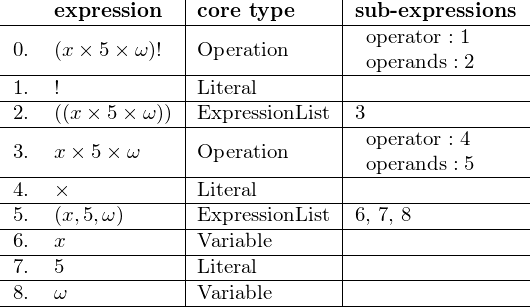

In [54]:
nestedOperation.exprInfo()

### Operand substitution

*Substitution* (or *relabeling*) of *operands* is straightforward in the way it works.

In [55]:
nestedOperationFromSub = xFactorial.substituted({x:multExpr})
nestedOperationFromSub

Internally, however, it is using the `Operation.make` which uses the `operatorOfOperation` class method of **Factorial** and **Multiply** in order to regenerate these objects and construct them with the proper classes.

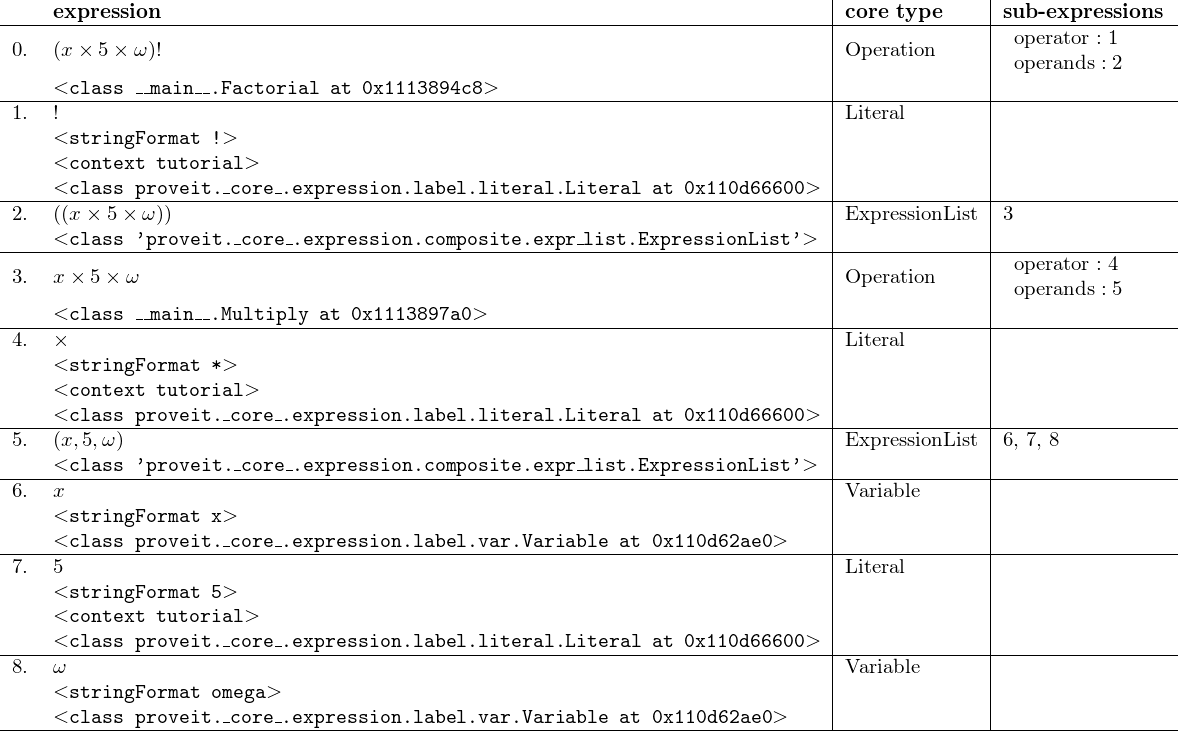

In [56]:
# Note that the classes are as they should be
nestedOperationFromSub.exprInfo(details=True)

In [57]:
# And this expression we obtained via substition is equivalent to the one constructed directly
print "Expressions, generated in different ways, are the same:", (nestedOperationFromSub == nestedOperation)

Expressions, generated in different ways, are the same: True


### Operator/operation substitution

The *operator* may likewise be substituted, but with some interesting extra capabilities.

It is straightforward to *relabel* a **Variable** *operator* with another **Variable**.

In [58]:
from proveit.common import g
fx.relabeled({f:g}) # Variable operator to a different Variable

And it is straightforward to *substitute* a **Variable** *operator* with a **Literal**.  This is generally not desirable, however, because it may not have the appropriate class.

In [59]:
xFactorialUndressed = fx.substituted({f:FACTORIAL}) # undressed by the Factorial class
xFactorialUndressed

In [60]:
xFactorialUndressed == xFactorial # Not the same

False

In [61]:
print xFactorialUndressed.__class__, 'vs', xFactorial.__class__ # the classes are different

proveit._core_.expression.operation.Operation vs __main__.Factorial


You can do *expression substitution* with **Literal** *operator*s, but you wouldn't be able to do such a thing with *specialization*.

In [62]:
xFactorialUndressed.substituted({FACTORIAL:SUMMATION}) # Literal operator to a different Literal operator

In [63]:
# But this will typically be prevented (appropriately) in trying to remake a derived Operation class:
try:
    xFactorial.substituted({FACTORIAL:SUMMATION})
except ValueError as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Unexpected operator, sum, when making __main__.Factorial


The more interesting case is to *substitute* the **Operation** itself.

In [64]:
fx.substituted({f:Lambda(y, Factorial(y))})

__*I'm still struggling with whether or not to allow **Lambda** *operator*s and how to do operation substitution.  It could do operation substitution in two steps: first substitute from a **Variable** to a **Lambda** operator and then perform the function application (in the lambda calculus style).  But I kind of like having it in one step.  As two steps, proof structures will get longer.  Operation substitution is used a lot when performing equality substition, $\forall_{f, x, y} x = y \Rightarrow f(x) = f(y)$.  So it comes up a lot.  And I don't foresee needing to explicitly treat Lambda operators, but it might be good to have the option.*__

In [65]:
# Use Lambda operators, or not??
Operation(Lambda(x, FIVE), omega)

NamedExpressions
=========

**NamedExpressions** is a composite **Expression** that makes string keywords to sub-**Expression**s.  The reason to do this is to be explicit in the internal representation about the role of each sub-**Expression** so there is no ambiguity between the internal and external representation.  The following example shows how **NamedExpressions** is used by `proveit._generic_.genericOps.OperationOverInstances` (aliased as `proveit.OperationOverInstances`) for such purposes.

In [66]:
from proveit import OperationOverInstances

In [67]:
class Summation(OperationOverInstances):
    def __init__(self, indices, summand, domain): 
        OperationOverInstances.__init__(self, SUMMATION, indices, summand, domain)

    @classmethod
    def operatorOfOperation(subClass):
        return SUMMATION 

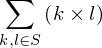

In [68]:
from proveit.common import k, l, S
summationExpr = Summation([k, l], Multiply(k, l), S)
summationExpr

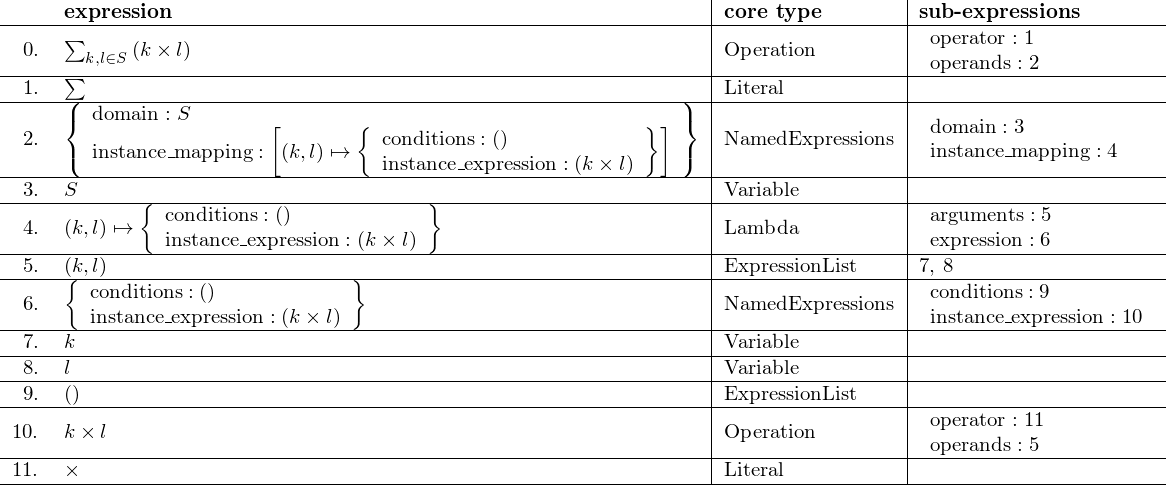

In [69]:
summationExpr.exprInfo()

As seen above, **NamedExpressions** is used to explicity define the `domain`, `instance_mapping`, `conditions`, and `instance_expression` roles.  We are not utilizing `conditions`, so it is an empty **ExpressionList**.  We'll see how it is used later.

**NamedExpressions** can be used more generally.  Here is an arbitrary example to show how it works.

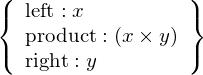

In [70]:
from proveit import NamedExpressions
NamedExpressions({'left':x, 'right':y, 'product':Multiply(x, y)})

Note that the ordering is arbitrary.  It is only the keyword strings that matter.

**ExpressionList**, 1-D **MultiVariable**s, and **Etcetera**
=================================

### ExpressionList

We have seen examples of **ExpressionList**s above.  On its own, it is simple.  It becomes more interesting as we discuss **MultiVariable** and **Etcetera** **Expression**s.

In [71]:
from proveit import ExpressionList
xyz = ExpressionList(x, y, z)
xyz

In [72]:
# Substitution is straightforward
fancyList = xyz.substituted({z:nestedOperation})
fancyList

In [73]:
# Let's keep it up
fancierList = fancyList.substituted({x:nestedOperation})
fancierList

Directly nesting **ExpressionList**s is not allowed.  They may be indirectly nested.  For example, you can nest a multi-operand **Operation** within an operand of an outer multi-operand **Operation**.

In [74]:
from proveit import NestedCompositeExpressionError
try:
    ExpressionList(x, ExpressionList(y, z))
except NestedCompositeExpressionError as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: May not nest ExpressionLists (do you need to use etcetera? or ExpressionTensor?)


### MultiVariable

A MultiVariable represents zero or more Variables in one Label.

In [75]:
r = MultiVariable('r', latexFormat=r'\vec{r}')
r # has a dummy index (box by default) to indicate that it can be expanded to a list of Variables

In [76]:
# The default dummy index may be overridden
q = MultiVariable('q', axesLabels=[Label('@', r'\triangle')])
q

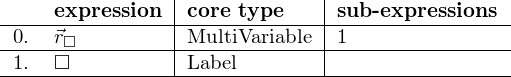

In [77]:
# Looking at r's expression information, we see that the dummy index is regarded as a Label sub-expression.
r.exprInfo()

With *expression relabeling*, a **MultiVariable** may change into a different **MultiVariable**.

In [78]:
r.relabeled({r:q})

You may *relabel* a **MultiVariable** as a **ExpressionList** of **Variable**s, but only within an **Etcetera** as we shall see.

In [79]:
try:
    r.relabeled({r:[x, y, z]})
except ImproperRelabeling as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: May only relabel MultiVariable to Variable or MultiVariable (or a list/tensor of Variables within an Etcetera/Block)


You may *relabel* a **MultiVariable** as a single **Variable**.  This is utilized internally when relabeling a **MultiVariable** within an **Etcetera**.

In [80]:
r.relabeled({r:x})

### Etcetera

An **Etcetera** is a placeholder for a portion of an **ExpressionList**.  In combination with **MultiVariable**s, you can do some interesting things.

In [81]:
from proveit import Etcetera
# This example shows how to map 1 or more arguments to the product of these arguments
multiMultiplyMap = Lambda([Etcetera(r), omega], Multiply(Etcetera(r), omega))
multiMultiplyMap

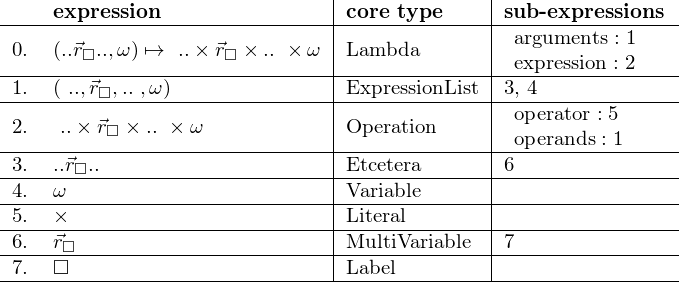

In [82]:
multiMultiplyMap.exprInfo()

Note the formatting which makes it clear that each of $\vec{r}$'s members will be in the product.  This formatting is defined in `proveit._generic_.genericOps.AssociativeOperation` (via `from ... import ...` statements within `__init__.py` files).  Indeed, this is what happens when we *relabel* (or *substitute*) $\vec{r}$. 

In [83]:
specificMultiMultiplyMap = multiMultiplyMap.relabeled({r:[x, y, z]})
specificMultiMultiplyMap

Notice how the expansion of $r$ is incorporated into the **ExpressionList**s rather than nesting the **ExpressionList**s (which, as mentioned above, is not allowed).

*Expression substitution* works similarly but is more general.

In [84]:
multiMultiplyMap.substituted({r:[x, FIVE, Factorial(z)]})

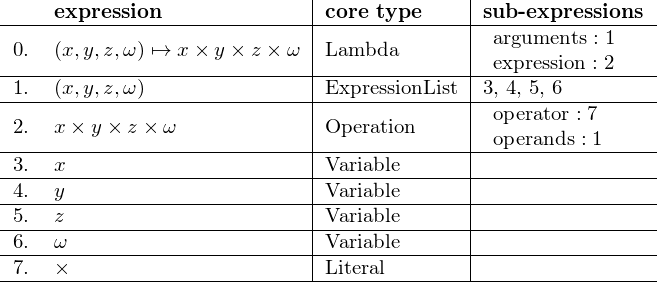

In [85]:
specificMultiMultiplyMap.exprInfo()

If that was the only thing we could do with **Etcetera**, there would be no good reason to have **Etcetera** and **MultiVariable** be separate core types.  But there is a good reason for have these separate as we shall see in the next example.

In [86]:
multiMultipliedFactorialMap = Lambda([Etcetera(r), omega], Multiply(Etcetera(Factorial(r)), Factorial(omega)))
multiMultipliedFactorialMap

In [87]:
multiMultipliedFactorialMap.relabeled({r:[x, y, z]})

Generally, you could have a **MultiVariable** within any kind of **Expression** that is within an **Etcetera**.  However, an exception will be thrown if there is ambiguity (relabeling multiple **MultiVariable**s within **Etcetera**).

In [88]:
ambiguousEtc = Etcetera(Multiply(r, q))
ambiguousEtc

In [89]:
try:
    ambiguousEtc.relabeled({r:[x, y, z], q:[omega, x]})
except Exception as e:
    print "EXPECTED ERROR:", e

EXPECTED ERROR: Multiple Bundle variable expansion is unsupported due to ambiguity


**ExpressionTensor**, multi-dimensional **MultiVariable**s, and **Block**
=================================

**ExpressionTensor** is a generalization of **ExpressionList** to multiple dimensions.  **MultiVariable**s can have multiple indices to generalize into multiple dimensions.  A **Block** is a generalization of **Etcetera** into multiple dimensions.


### ExpressionTensor

**ExpressionTensor**s are represented as a Python dictionary that maps tuples of indices into **Expression** elements.  They can be sparse.


__*I am still trying to decide how to implement Block substitution in ExpressionTensors.  The difficulty is that a Block can expand in multiple directions and we need to define how this expansion occurs (in 1-D, there is no ambiguity).  In particular, I'm thinking of how to treat circuit diagrams (analog, digital, or quantum circuits) where you can think of pins entering/exiting the Block within an ExpressionTensor and you can think of pins entering/exiting an ExpressionTensor itself.  When substituting an ExpressionTensor into a Block, you want to line up the pins and expand the space as needed.  How to do this exactly in a way that is both flexible but as straightforward as possible?  I thought of alignment indices, but I've also lately been thinking of defining anchor points which would be more flexible and could correspond to the "pin" concept.*__

### Multi-dimensional **MultiVariables**

In [90]:
# Can also be used to represent a multi-dimensional array of Variables
A = MultiVariable('A', numDimensions=2)
A # a box and triangle are used as the multi-dimensional dummy indices

In [91]:
# The default dummy indices may be overridden
B = MultiVariable('B', numDimensions=2, axesLabels=[Label('@', r'\triangle'), Label('*', r'\Box')])
B # switched the triangle and box just to show we can

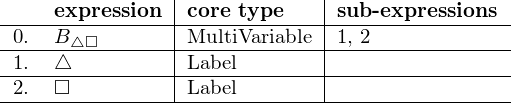

In [92]:
# Looking at B's expression information, we see that the dummy indices are regarded as Label sub-expressions.
B.exprInfo()

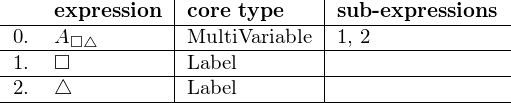

In [93]:
B.relabeled({B:A}).exprInfo()

In [94]:
# The dimensionality must match when relabeling
try:
    r.relabeled({r:A})
except ValueError as e:
    print "EXPECTED ERROR:", e

### Block

**Etcetera** with **MultiVariable**s

An **Etcetera** is a placeholder for a portion of an **ExpressionList**.  A **MultiVariable** is a placeholder for multiple 